<a href="https://colab.research.google.com/github/amanjaiswal777/ICCIT-Workshop/blob/main/02_movie_recommendations_user_cf_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 Movie Recommendations — User-Based Collaborative Filtering
This notebook builds an end-to-end user-based collaborative filtering recommender using synthetic data. It includes dataset generation, similarity computation, visualization, prediction, evaluation, and an interactive recommendation function.

## 🎯 Learning Objectives
- Generate a sparse user-item rating matrix
- Compute cosine similarity between users
- Visualize similarity matrices and user networks
- Implement user-based collaborative filtering (neighbor-based)
- Evaluate recommendations with RMSE and Top-N checks
- Discuss real-world differences (Netflix vs Spotify)


## 📦 Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sns.set_theme(style="whitegrid")
rng = np.random.default_rng(42)


## 🔬 1) Synthetic Ratings Data Generation
We simulate latent user/item factors then generate noisy ratings and introduce realistic sparsity (~85% missing).

In [2]:
# Parameters
n_users = 250
n_items = 180
latent_k = 6

# Latent factors
U = rng.normal(0, 1, (n_users, latent_k))
V = rng.normal(0, 1, (n_items, latent_k))

# Base ratings from latent factors
base_ratings = 3.0 + (U @ V.T) / 2.0  # center around 3.0, scaled

# Add noise and clip to 0.5-5.0
ratings = base_ratings + rng.normal(0, 0.6, base_ratings.shape)
ratings = np.clip(ratings, 0.5, 5.0)

# Introduce sparsity: only 15% observed
mask = rng.uniform(0, 1, ratings.shape) < 0.15
R_obs = np.where(mask, ratings, np.nan)

# Create DataFrame
users = [f"U{i:03d}" for i in range(n_users)]
items = [f"M{i:03d}" for i in range(n_items)]
R = pd.DataFrame(R_obs, index=users, columns=items)

print('Users:', n_users, 'Items:', n_items)
print('Observed fraction:', np.isfinite(R.values).mean().round(3))
R.iloc[:6, :8].head()


Users: 250 Items: 180
Observed fraction: 0.148


,M000,M001,M002,M003,M004,M005,M006,M007
U000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U001,NaN,NaN,NaN,NaN,NaN,NaN,1.794861,NaN
U002,NaN,NaN,NaN,NaN,3.178635,NaN,NaN,NaN
U003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 📊 2) Exploratory Data Analysis

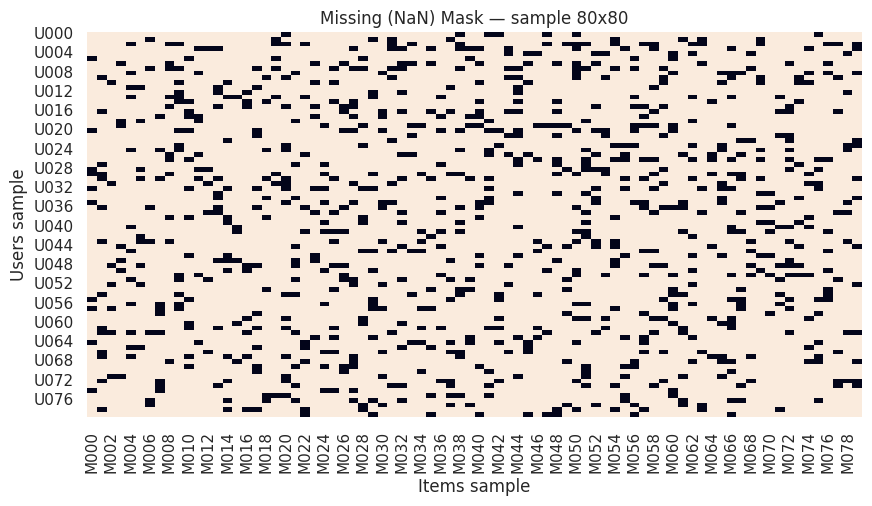

In [3]:
# Visualize sparsity pattern (sample)
plt.figure(figsize=(10,5))
sns.heatmap(pd.isna(R).iloc[:80, :80], cbar=False)
plt.title('Missing (NaN) Mask — sample 80x80')
plt.xlabel('Items sample')
plt.ylabel('Users sample')
plt.show()

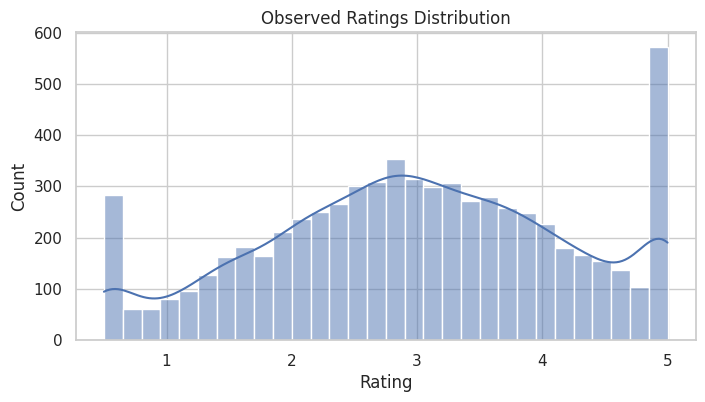

In [4]:
# Distribution of observed ratings
plt.figure(figsize=(8,4))
sns.histplot(R.stack(), bins=30, kde=True)
plt.title('Observed Ratings Distribution')
plt.xlabel('Rating')
plt.show()

## 🧮 3) Compute User Similarity (Cosine)

In [5]:
# Fill missing values with user mean for similarity computation
R_filled = R.apply(lambda row: row.fillna(row.mean()), axis=1)

# Cosine similarity between users
S = pd.DataFrame(cosine_similarity(R_filled), index=users, columns=users)
S.iloc[:6, :6]

,U000,U001,U002,U003,U004,U005
U000,1.000000,0.982891,0.986150,0.982400,0.992341,0.978919
U001,0.982891,1.000000,0.984484,0.984484,0.988539,0.980477
U002,0.986150,0.984484,1.000000,0.983099,0.989005,0.978646
U003,0.982400,0.984484,0.983099,1.000000,0.987787,0.978443
U004,0.992341,0.988539,0.989005,0.987787,1.000000,0.984567
U005,0.978919,0.980477,0.978646,0.978443,0.984567,1.000000


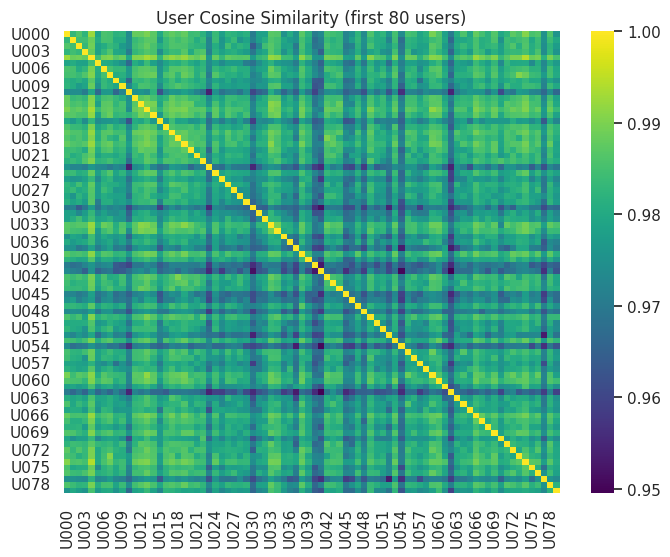

In [6]:
# Visualize a block of the similarity matrix
plt.figure(figsize=(8,6))
sns.heatmap(S.iloc[:80, :80], cmap='viridis')
plt.title('User Cosine Similarity (first 80 users)')
plt.show()

## 🌐 4) User Similarity Network Visualization

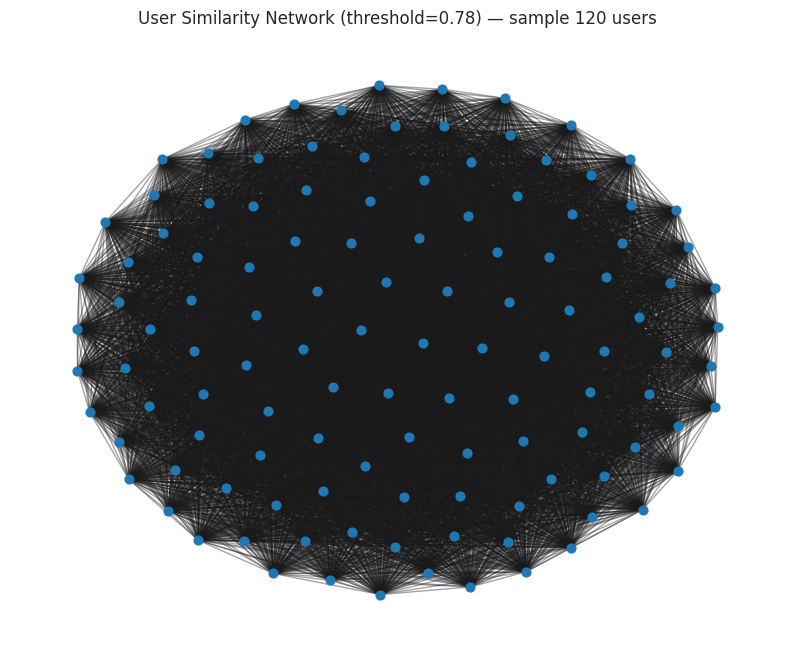

In [7]:
# Build graph connecting users with similarity > threshold
threshold = 0.78
G = nx.Graph()
sample_users = users[:120]  # visualize subset

for u in sample_users:
    sims = S.loc[u, sample_users].drop(u)
    for v, sim in sims.items():
        if sim > threshold:
            G.add_edge(u, v, weight=float(sim))

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.title(f'User Similarity Network (threshold={threshold}) — sample {len(sample_users)} users')
plt.axis('off')
plt.show()

## 🧩 5) User-Based Collaborative Filtering — Prediction Function
We implement a neighborhood-based predictor using top-k similar users and mean-centering.

In [8]:
def predict_user_based(R, S, k=20):
    """Predict full rating matrix using user-based CF with top-k neighbors.
    R: DataFrame with NaNs for missing
    S: similarity DataFrame (users x users)
    k: number of neighbors
    Returns: DataFrame of predictions
    """
    R_mean = R.mean(axis=1)
    R_demeaned = R.sub(R_mean, axis=0)
    R_pred = pd.DataFrame(index=R.index, columns=R.columns, dtype=float)

    for u in R.index:
        # top-k neighbors excluding self
        neighbors = S.loc[u].drop(u).nlargest(k).index
        sims = S.loc[u, neighbors].values
        # weighted sum (handle NaNs by skipna)
        num = (R_demeaned.loc[neighbors].multiply(sims[:, None], axis=0)).sum(axis=0, skipna=True)
        den = np.abs(sims).sum()
        # if den==0 fallback to user mean
        pred = R_mean[u] + num / (den + 1e-8)
        R_pred.loc[u] = pred
    return R_pred

# Quick run on our full matrix (may take a little time)
R_pred = predict_user_based(R, S, k=20)
R_pred.iloc[:5, :5]


,M000,M001,M002,M003,M004
U000,3.501973,3.586272,3.409131,3.487201,3.531827
U001,2.613557,2.823689,2.460109,2.635431,2.509273
U002,3.109764,3.140571,2.985995,3.130774,2.939827
U003,2.664335,2.712300,2.583524,2.667716,2.560054
U004,3.420266,3.500252,3.246676,3.391506,3.269957


## 🧪 6) Evaluation — Holdout RMSE
We create a test set by hiding a subset of observed ratings and compute RMSE.

In [9]:
# Build train/test by masking a subset of observed entries
obs_idx = np.argwhere(~np.isnan(R.values))
n_test = min(3000, len(obs_idx)//5)
test_sel = rng.choice(len(obs_idx), size=n_test, replace=False)
test_pairs = obs_idx[test_sel]

R_train = R.copy()
test_truth = []
for u_i, m_i in test_pairs:
    test_truth.append(R_train.iat[u_i, m_i])
    R_train.iat[u_i, m_i] = np.nan
test_truth = np.array(test_truth)

# Recompute similarity on train (fill with user means)
R_filled_train = R_train.apply(lambda row: row.fillna(row.mean()), axis=1)
S_train = pd.DataFrame(cosine_similarity(R_filled_train), index=users, columns=users)

R_pred_train = predict_user_based(R_train, S_train, k=20)

# Evaluate on test pairs
test_preds = []
for (u_i, m_i) in test_pairs:
    u = users[u_i]; m = items[m_i]
    test_preds.append(R_pred_train.at[u, m])
test_preds = np.array(test_preds)

rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
print('Holdout RMSE:', round(rmse, 4))

Holdout RMSE: 1.2179


## 🔎 7) Interactive: Get Top-N Recommendations for a User

In [10]:
def recommend_for_user(user_id, R, R_pred, top_n=10, exclude_seen=True):
    """Return top-N item recommendations for a given user using predicted ratings."""
    if user_id not in R.index:
        raise ValueError('Unknown user')
    preds = R_pred.loc[user_id].sort_values(ascending=False)
    if exclude_seen:
        seen = R.loc[user_id].dropna().index
        preds = preds.drop(labels=seen, errors='ignore')
    return preds.head(top_n)

# Example: Recommend for user U000
user = users[0]
top10 = recommend_for_user(user, R, R_pred, top_n=10)
print('Top-10 recommendations for', user)
display(top10)

Top-10 recommendations for U000


,U000
M037,3.645421
M029,3.603837
M129,3.597268
M001,3.586272
M046,3.582730
M164,3.574039
M013,3.570168
M051,3.560674
M110,3.560348
M058,3.558037


## 🔬 8) Item-Based CF (Optional) — Sketch Implementation

In [11]:
# Compute item-item similarity (fill NaNs with item mean)
R_filled_item = R.apply(lambda col: col.fillna(col.mean()), axis=0)
S_item = pd.DataFrame(cosine_similarity(R_filled_item.T), index=items, columns=items)

def predict_item_based(R, S_item, k=20):
    R_pred = pd.DataFrame(index=R.index, columns=R.columns, dtype=float)
    for i in R.columns:
        sims = S_item.loc[i].drop(i).nlargest(k)
        neighbors = sims.index
        sim_vals = sims.values
        num = (R[neighbors].multiply(sim_vals, axis=1)).sum(axis=1, skipna=True)
        den = np.abs(sim_vals).sum() + 1e-8
        R_pred[i] = num / den
    return R_pred

R_pred_item = predict_item_based(R, S_item, k=20)
R_pred_item.iloc[:4, :6]

,M000,M001,M002,M003,M004,M005
U000,0.496508,0.884896,0.527498,0.302493,0.799206,0.527567
U001,0.513799,0.634594,0.442235,0.576135,0.418180,0.489443
U002,0.461174,0.794933,0.486447,0.505504,0.630244,0.649124
U003,0.294334,0.401885,0.596537,0.670330,0.294526,0.916720


## 📈 9) Top-N Evaluation (Precision@K style)
We compute how many of the held-out test items appear in the Top-N recommendations for each user.

In [12]:
# Build a small test set per user: hide one rating per some users
# (reuse test_pairs from earlier; convert to per-user ground truth)
from collections import defaultdict
user_holdouts = defaultdict(list)
for (u_i, m_i), val in zip(test_pairs, test_truth):
    user_holdouts[users[u_i]].append((items[m_i], val))

# Evaluate Precision@10
def precision_at_k(R_train, R_pred, user_holdouts, k=10):
    hits = 0
    total = 0
    for u, holdouts in user_holdouts.items():
        preds = recommend_for_user(u, R_train, R_pred, top_n=k)
        pred_items = set(preds.index)
        for (item, true_val) in holdouts:
            total += 1
            if item in pred_items:
                hits += 1
    return hits / total if total>0 else np.nan

prec10 = precision_at_k(R_train, R_pred_train, user_holdouts, k=10)
print('Precision@10 (holdout):', round(prec10,4))

Precision@10 (holdout): 0.0608


## 🧾 10) Netflix vs Spotify — Practical Differences
- **Netflix** (movies/TV): Item catalog changes slowly; user tastes have temporal shifts; strong item metadata and sessions.
- **Spotify** (music): Catalog is huge, listen events are abundant; short-term recency and session-based recommendations matter.

Discuss how sparsity, feedback types (explicit ratings vs implicit plays), and evaluation metrics differ.

## 🎯 Assignment
1. Try different values of `k` in the user-based CF and observe RMSE and Precision@10.
2. Implement mean-centering for items (item bias) in predictions.
3. Swap to item-based CF and compare results.
4. (Advanced) Implement a simple matrix factorization (SVD) baseline and compare RMSE.

Write your answers/codes below.

In [13]:
# 🚀 Your experiments here
# Example: re-run predict_user_based with k=5, k=50 and compare.


## ✅ Assignment Solutions (Reference) — Hidden
Below are suggested solution snippets. Uncomment to run.

In [14]:
# --- SOLUTION EXAMPLES ---
# 1) Try k variation:
# for k in [5, 10, 20, 50]:
#     R_pred_k = predict_user_based(R_train, S_train, k=k)
#     test_preds_k = []
#     for (u_i, m_i) in test_pairs:
#         u = users[u_i]; m = items[m_i]
#         test_preds_k.append(R_pred_k.at[u, m])
#     rmse_k = np.sqrt(mean_squared_error(test_truth, np.array(test_preds_k)))
#     print('k=', k, 'RMSE=', round(rmse_k,4))
#
# 2) Item-based compare (already computed above as R_pred_item):
# test_preds_item = []
# for (u_i, m_i) in test_pairs:
#     u = users[u_i]; m = items[m_i]
#     test_preds_item.append(R_pred_item.at[u, m])
# print('Item-based RMSE=', round(np.sqrt(mean_squared_error(test_truth, np.array(test_preds_item))),4))
#
# 3) Quick SVD baseline using numpy (very simple):
# from numpy.linalg import svd
# R_filled_for_svd = R.fillna(R.mean().mean()).values
# U_s, s_s, Vt_s = svd(R_filled_for_svd, full_matrices=False)
# k_svd = 20
# S_mat = np.diag(s_s[:k_svd])
# U_k = U_s[:, :k_svd] @ S_mat
# V_k = Vt_s[:k_svd, :]
# R_svd_pred = pd.DataFrame(U_k @ V_k, index=users, columns=items)
# test_preds_svd = []
# for (u_i, m_i) in test_pairs:
#     test_preds_svd.append(R_svd_pred.iat[u_i, m_i])
# print('SVD RMSE:', round(np.sqrt(mean_squared_error(test_truth, np.array(test_preds_svd))),4))
